# Quantum Process Tomography Benchmarks

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from lindblad_channels import *
from quantum_tools import *
from experimental import *
from spam import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Recover Map

### Generate True Model, Full POVM and Inital

In [2]:
def generate_spam_benchmark(n=3, c1=1, c2=1):
    d = 2**n

    init_target = InitialState(d, c=c1)
    povm_target = POVM(d, c=c2)

    spam_target = SPAM(init = init_target,
                       povm = povm_target)
    
    return spam_target


def generate_spam_data(spam_target, N_spam=None, shots=1024):
    n = int(np.log2(spam_target.d))
    inputs_spam, _ = generate_pauliInput_circuits(n)
    N_spam = inputs_spam.shape[0]

    state = tf.repeat(spam_target.init.init[None,:,:], N_spam, axis=0)
    targets_spam = measurement(state, U_basis = inputs_spam, povm = spam_target.povm.povm)

    #add noise
    targets_spam = add_shot_noise(targets_spam, shots = shots)
    return inputs_spam, targets_spam


def generate_map_data(channel_target, spam_target, N_map=None, shots=1024):
    n = int(np.log2(channel_target.d))
    inputs_map, _ = generate_pauli_circuits(n = n, 
                                            circuit_target=None,  
                                            trace=False,
                                            N=N_map)
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    state = tf.repeat(tf.expand_dims(spam_target.init.init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis, spam_target.povm.povm)
    
    #add noise
    targets_map = add_shot_noise(targets_map, shots = shots)

    return inputs_map, targets_map

## Three Qubits

### Generate Synthetic Data with Noise

In [3]:
n = 3
d = 2**n
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_target1 = generate_spam_benchmark(n=n, c1=0.9, c2=0.9)
inputs_spam1, targets_spam1 = generate_spam_data(spam_target1, N_spam=None, shots=1024)

### Fit Model, Initial and Corruption Matrix

In [4]:
np.random.seed(43)
random.seed(43)
tf.random.set_seed(43)

spam_model1 = SPAM(init = InitialState(d, c=0.9),
                  povm = CorruptionMatrix(d, c=0.9),
                  loss_function = ProbabilityMSE(),
                  optimizer = tf.optimizers.Adam(learning_rate=0.01)
                 )

spam_model1.train(inputs = inputs_spam1,
                  targets = targets_spam1,
                  num_iter = 2000,
                  verbose = False,
                 )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0007579578382171166


### Generate Random Quantum Channel

In [7]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

channel_target1 = DilutedKrausMap(U = generate_unitary(d), 
                                  c = 0.7,
                                  kraus_part = KrausMap(d=d, 
                                                        rank=7),
                                  spam = spam_target1)

inputs_map, targets_map = generate_map_data(channel_target1, spam_target1, N_map= 2000-6**n, shots=1024)

model1 = ModelQuantumMap(channel = KrausMap(d = d, 
                                            rank = d**2,
                                            spam = spam_model1,
                                            ),
                        loss_function = ProbabilityMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = ProbabilityMSE(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model1.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [channel_target1],
            num_iter = 1000,
            N = 500,
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

0.26100329433424513 -0.07721361302441213
0.04908339638205567 -0.45104780309241127
0.01120183403300308 -0.6713063864580742
0.008753637302988369 -0.740311166355345
0.007676255824555697 -0.7882631429798798
0.00709850012525041 -0.8226948941384734
0.00676036809182211 -0.8480461050202738
0.0065554469074765665 -0.8666265163480068
0.006426872100382463 -0.8798561986872812
0.00634593680716717 -0.8899217288664898
tf.Tensor((0.006478223886931986+2.5518603186883745e-20j), shape=(), dtype=complex128)
0.00628224183717613 -0.8975055660454296


In [10]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

channel_target2 = DilutedKrausMap(U = generate_unitary(d), 
                                  c = 0.5,
                                  kraus_part = KrausMap(d=d, 
                                                        rank=14),
                                  spam = spam_target1)

inputs_map, targets_map = generate_map_data(channel_target2, spam_target1, N_map=2000-6**n, shots=1024)

model2 = ModelQuantumMap(channel = KrausMap(d = d, 
                                           rank = d**2,
                                           spam = spam_model1,
                                          ),
                        loss_function = ProbabilityMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = ProbabilityMSE(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model2.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [channel_target2],
            num_iter = 1000,
            N = 500,
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

0.14585464535577586 -0.1550982879510441
0.023133220827635085 -0.48598464277055203
0.00971946131326356 -0.6493547086561383
0.0076723878538595075 -0.7287289796442483
0.0068238166008152325 -0.7790231724506751
0.00640942310024716 -0.811576161280375
0.006183449763942502 -0.8338940601015054
0.006050679576779318 -0.8500255142821733
0.0059699512257061675 -0.8614327509322105
0.0059173080367470625 -0.8694509258150226
tf.Tensor((0.005998925272495649+1.311646736978799e-19j), shape=(), dtype=complex128)
0.005881018863504014 -0.8760177000598304


In [11]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

channel_target3 = DilutedKrausMap(U = generate_unitary(d), 
                                  c = 0.35,
                                  kraus_part = KrausMap(d=d, 
                                                        rank=16),
                                  spam = spam_target1)

inputs_map, targets_map = generate_map_data(channel_target3, spam_target1, N_map=2000-6**n, shots=1024)

model3 = ModelQuantumMap(channel = KrausMap(d = d, 
                                           rank = d**2,
                                           spam = spam_model1,
                                          ),
                        loss_function = ProbabilityMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = ProbabilityMSE(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model3.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [channel_target3],
            num_iter = 1000,
            N = 500,
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

0.08968124953202139 -0.19676965374968738
0.016790776270254458 -0.4922431455990282
0.008827902914918435 -0.6550352248413446
0.007111149088731517 -0.7399124668652919
0.006449458145144934 -0.7898988616429576
0.006144955446249345 -0.820875800017307
0.005982160563779347 -0.8413397211165009
0.005893944809533505 -0.8557430076896004
0.005833060435694683 -0.8654390193442377
0.005803831572916346 -0.8722172010102878
tf.Tensor((0.005796849048630255-8.579833568804949e-20j), shape=(), dtype=complex128)
0.005781836007617298 -0.8778424864994265


In [12]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

channel_target4 = DilutedKrausMap(U = generate_unitary(d), 
                                  c = 0.2,
                                  kraus_part = KrausMap(d=d, 
                                                        rank=22),
                                  spam = spam_target1)

inputs_map, targets_map = generate_map_data(channel_target4, spam_target1, N_map=10000-6**n, shots=1024)

model4 = ModelQuantumMap(channel = KrausMap(d = d, 
                                           rank = d**2,
                                           spam = spam_model1,
                                          ),
                        loss_function = ProbabilityMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = ProbabilityMSE(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model4.train(inputs = inputs_map,
             targets = targets_map,
             inputs_val = None,
             targets_val = [channel_target4],
             num_iter = 1000,
             N = 500,
             )

  0%|          | 0/1000 [00:00<?, ?it/s]

0.0513881458637069 -0.278264077295933
0.013503018751367262 -0.5471131900116993
0.00846439953511304 -0.703618323870684
0.007275850101514544 -0.7847854228713909
0.006838033607896748 -0.8321902873778866
0.006635595057808672 -0.8620243342052696
0.006527191285119683 -0.8814529380298597
0.0064718347424089365 -0.8949894823106515
0.006434841133447393 -0.9042322183238376
0.006421266324657546 -0.9112324602428616
tf.Tensor((0.00635635779800106-1.1965266683340979e-19j), shape=(), dtype=complex128)
0.006399567689871025 -0.9164720642485537


In [ ]:
spectrum_model1 = channel_spectrum(model1.channel)
spectrum_target1 = channel_spectrum(channel_target1)

spectrum_model2 = channel_spectrum(model2.channel)
spectrum_target2 = channel_spectrum(channel_target2)

spectrum_model3 = channel_spectrum(model3.channel)
spectrum_target3 = channel_spectrum(channel_target3)

spectrum_model4 = channel_spectrum(model4.channel)
spectrum_target4 = channel_spectrum(channel_target4)

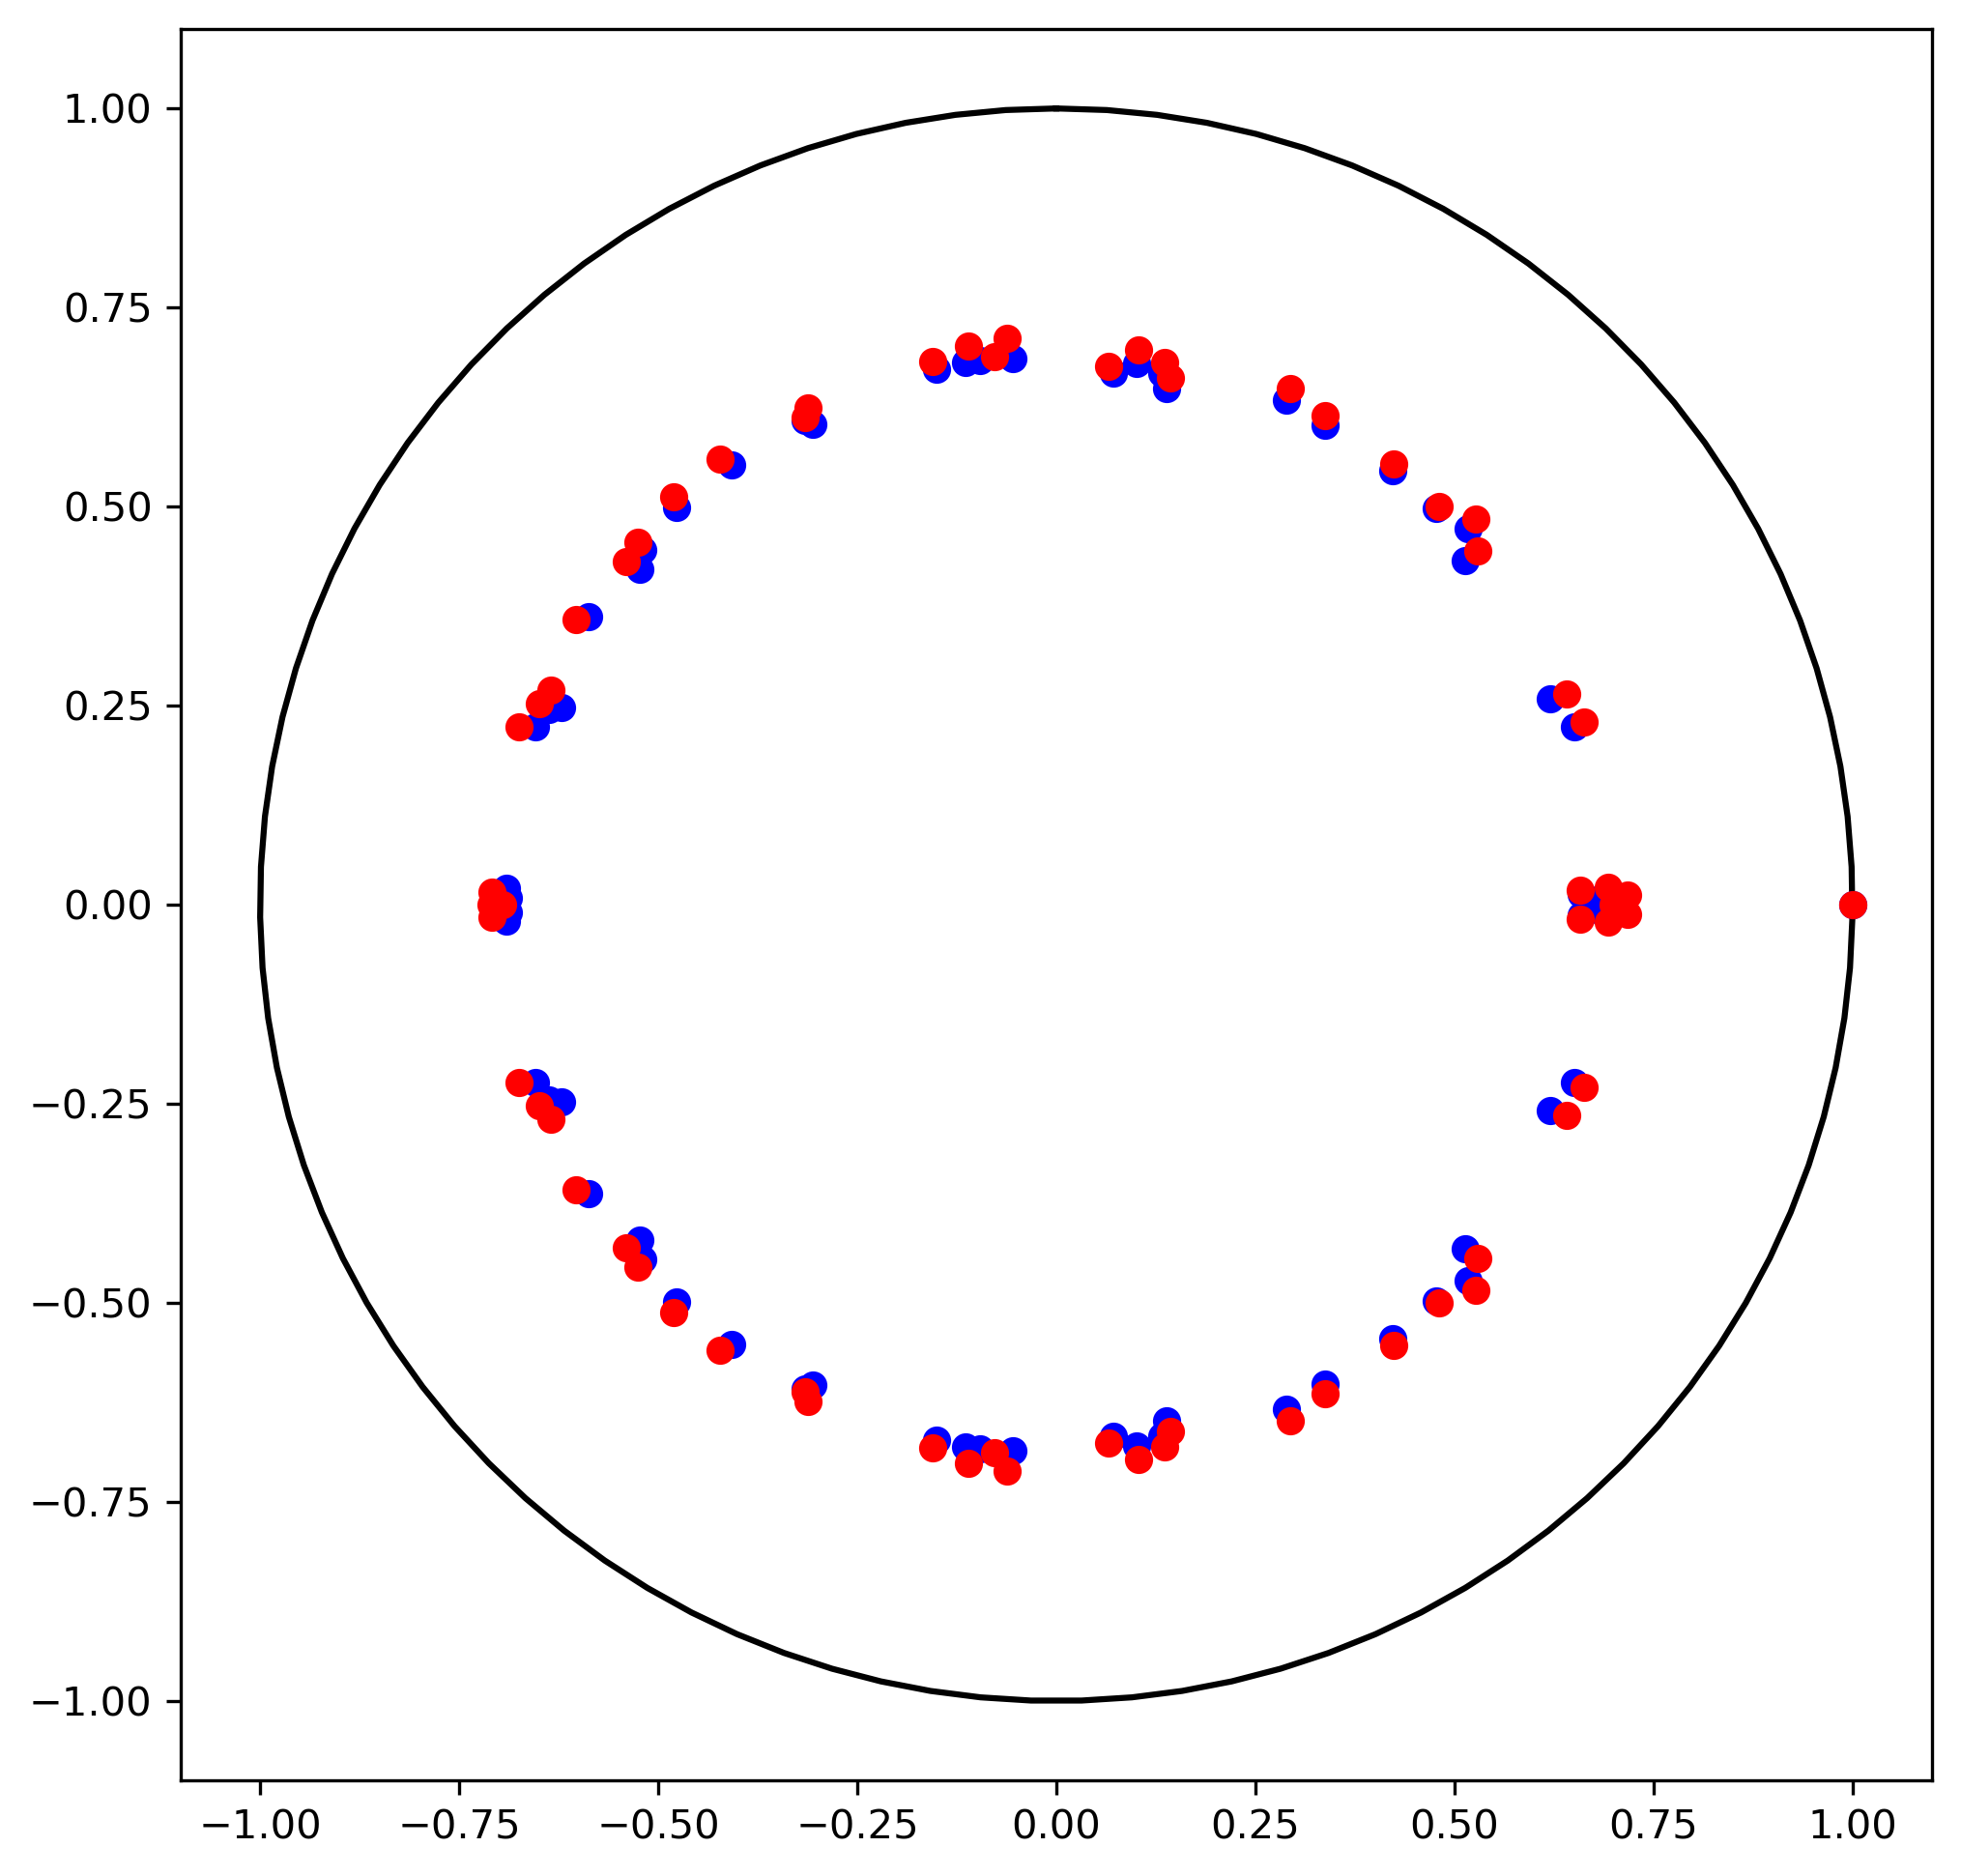

In [20]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "bo")
plt.plot(spectrum_target1[:,0], spectrum_target1[:,1], "ro")

plt.show()

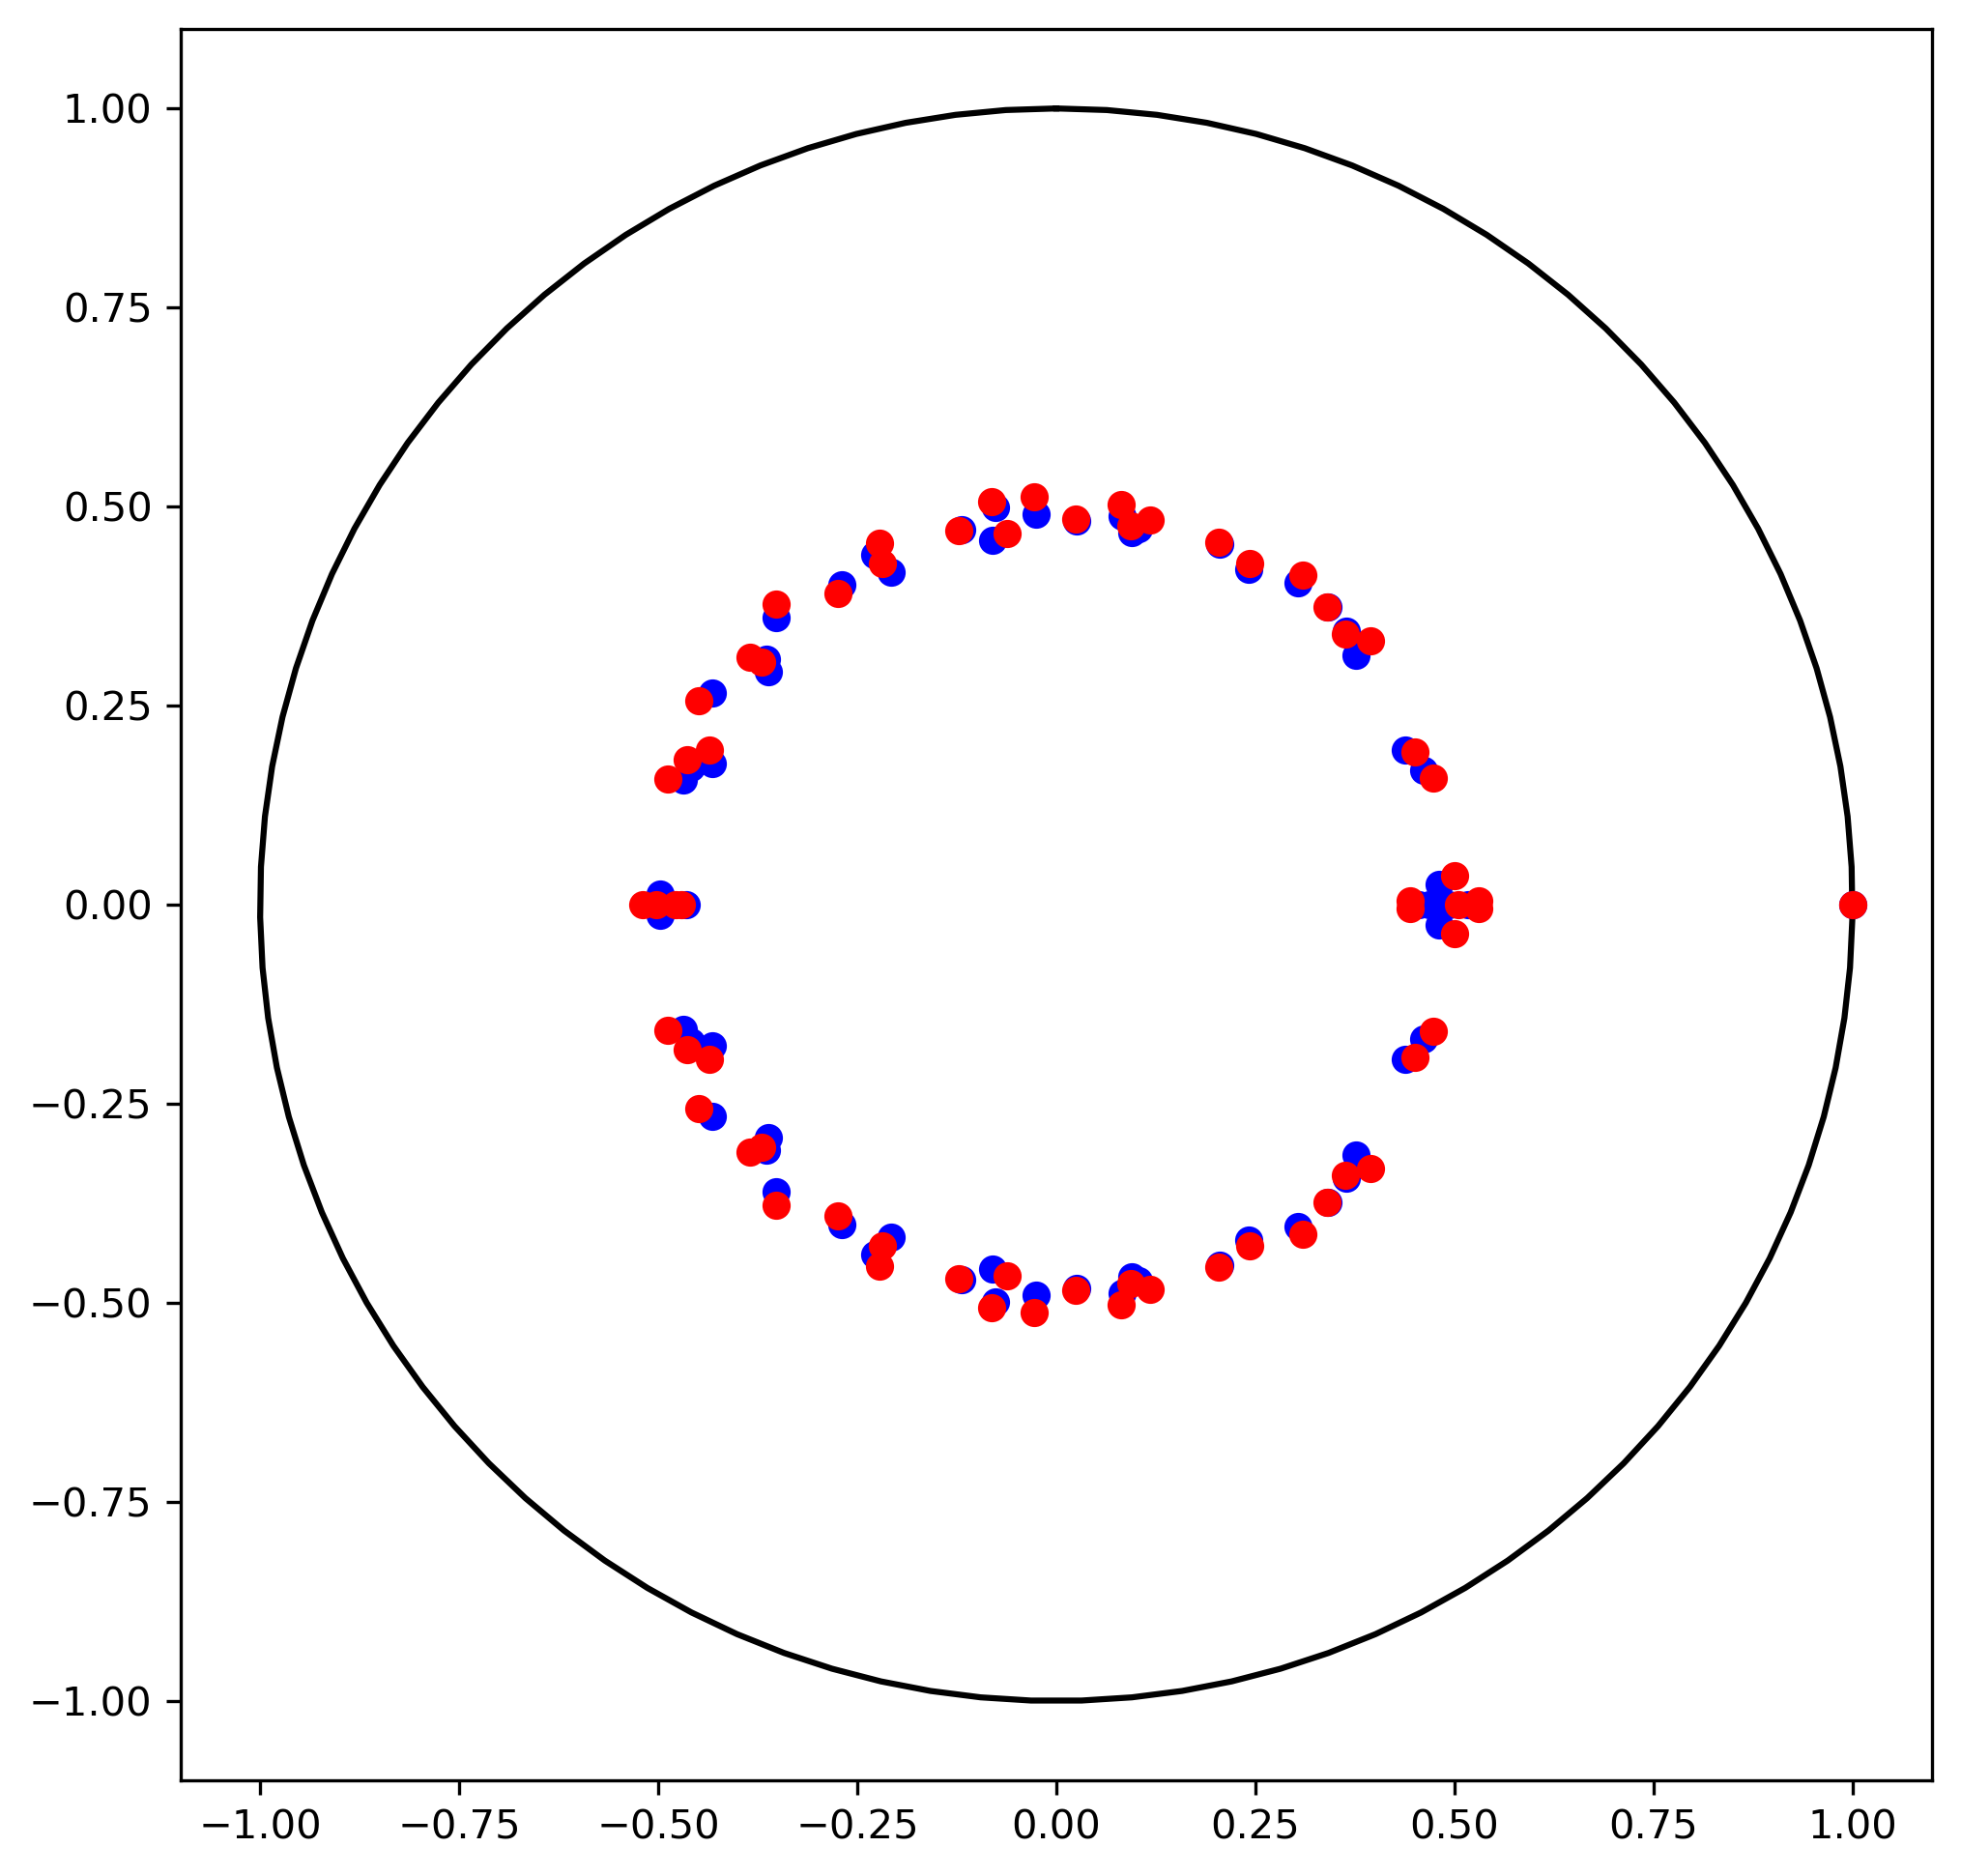

In [21]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "bo")
plt.plot(spectrum_target2[:,0], spectrum_target2[:,1], "ro")

plt.show()

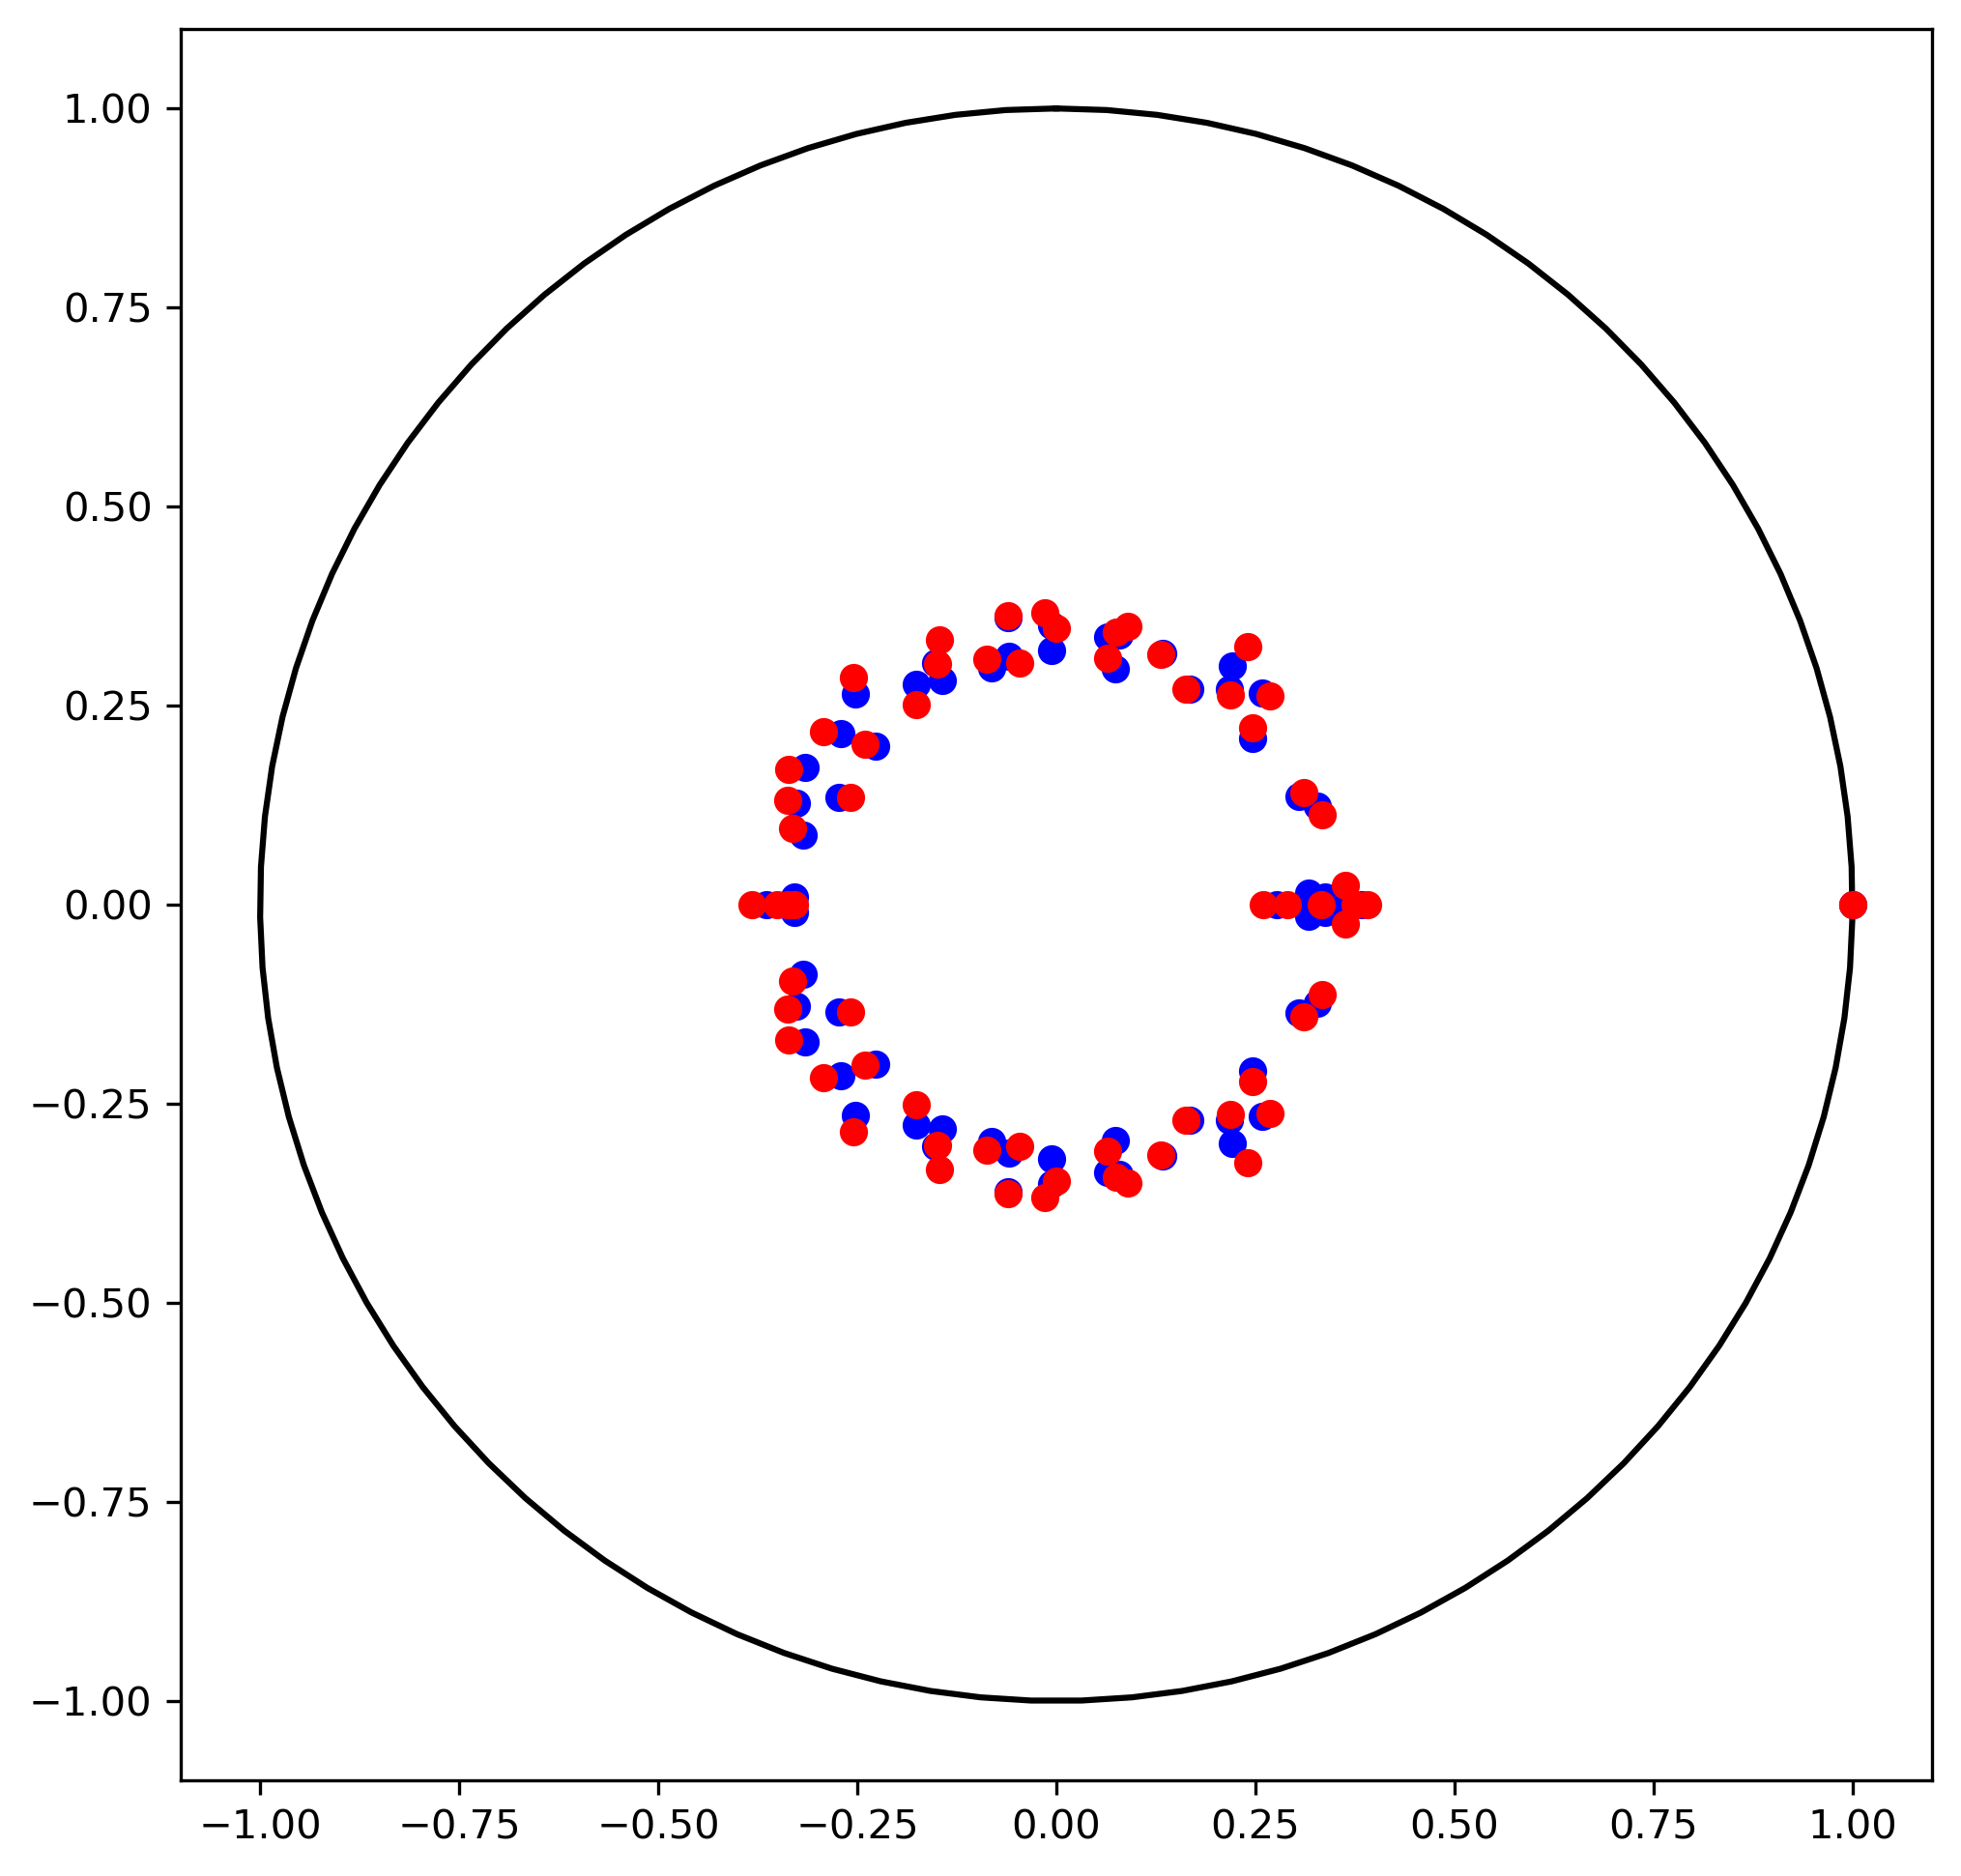

In [22]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "bo")
plt.plot(spectrum_target3[:,0], spectrum_target3[:,1], "ro")

plt.show()

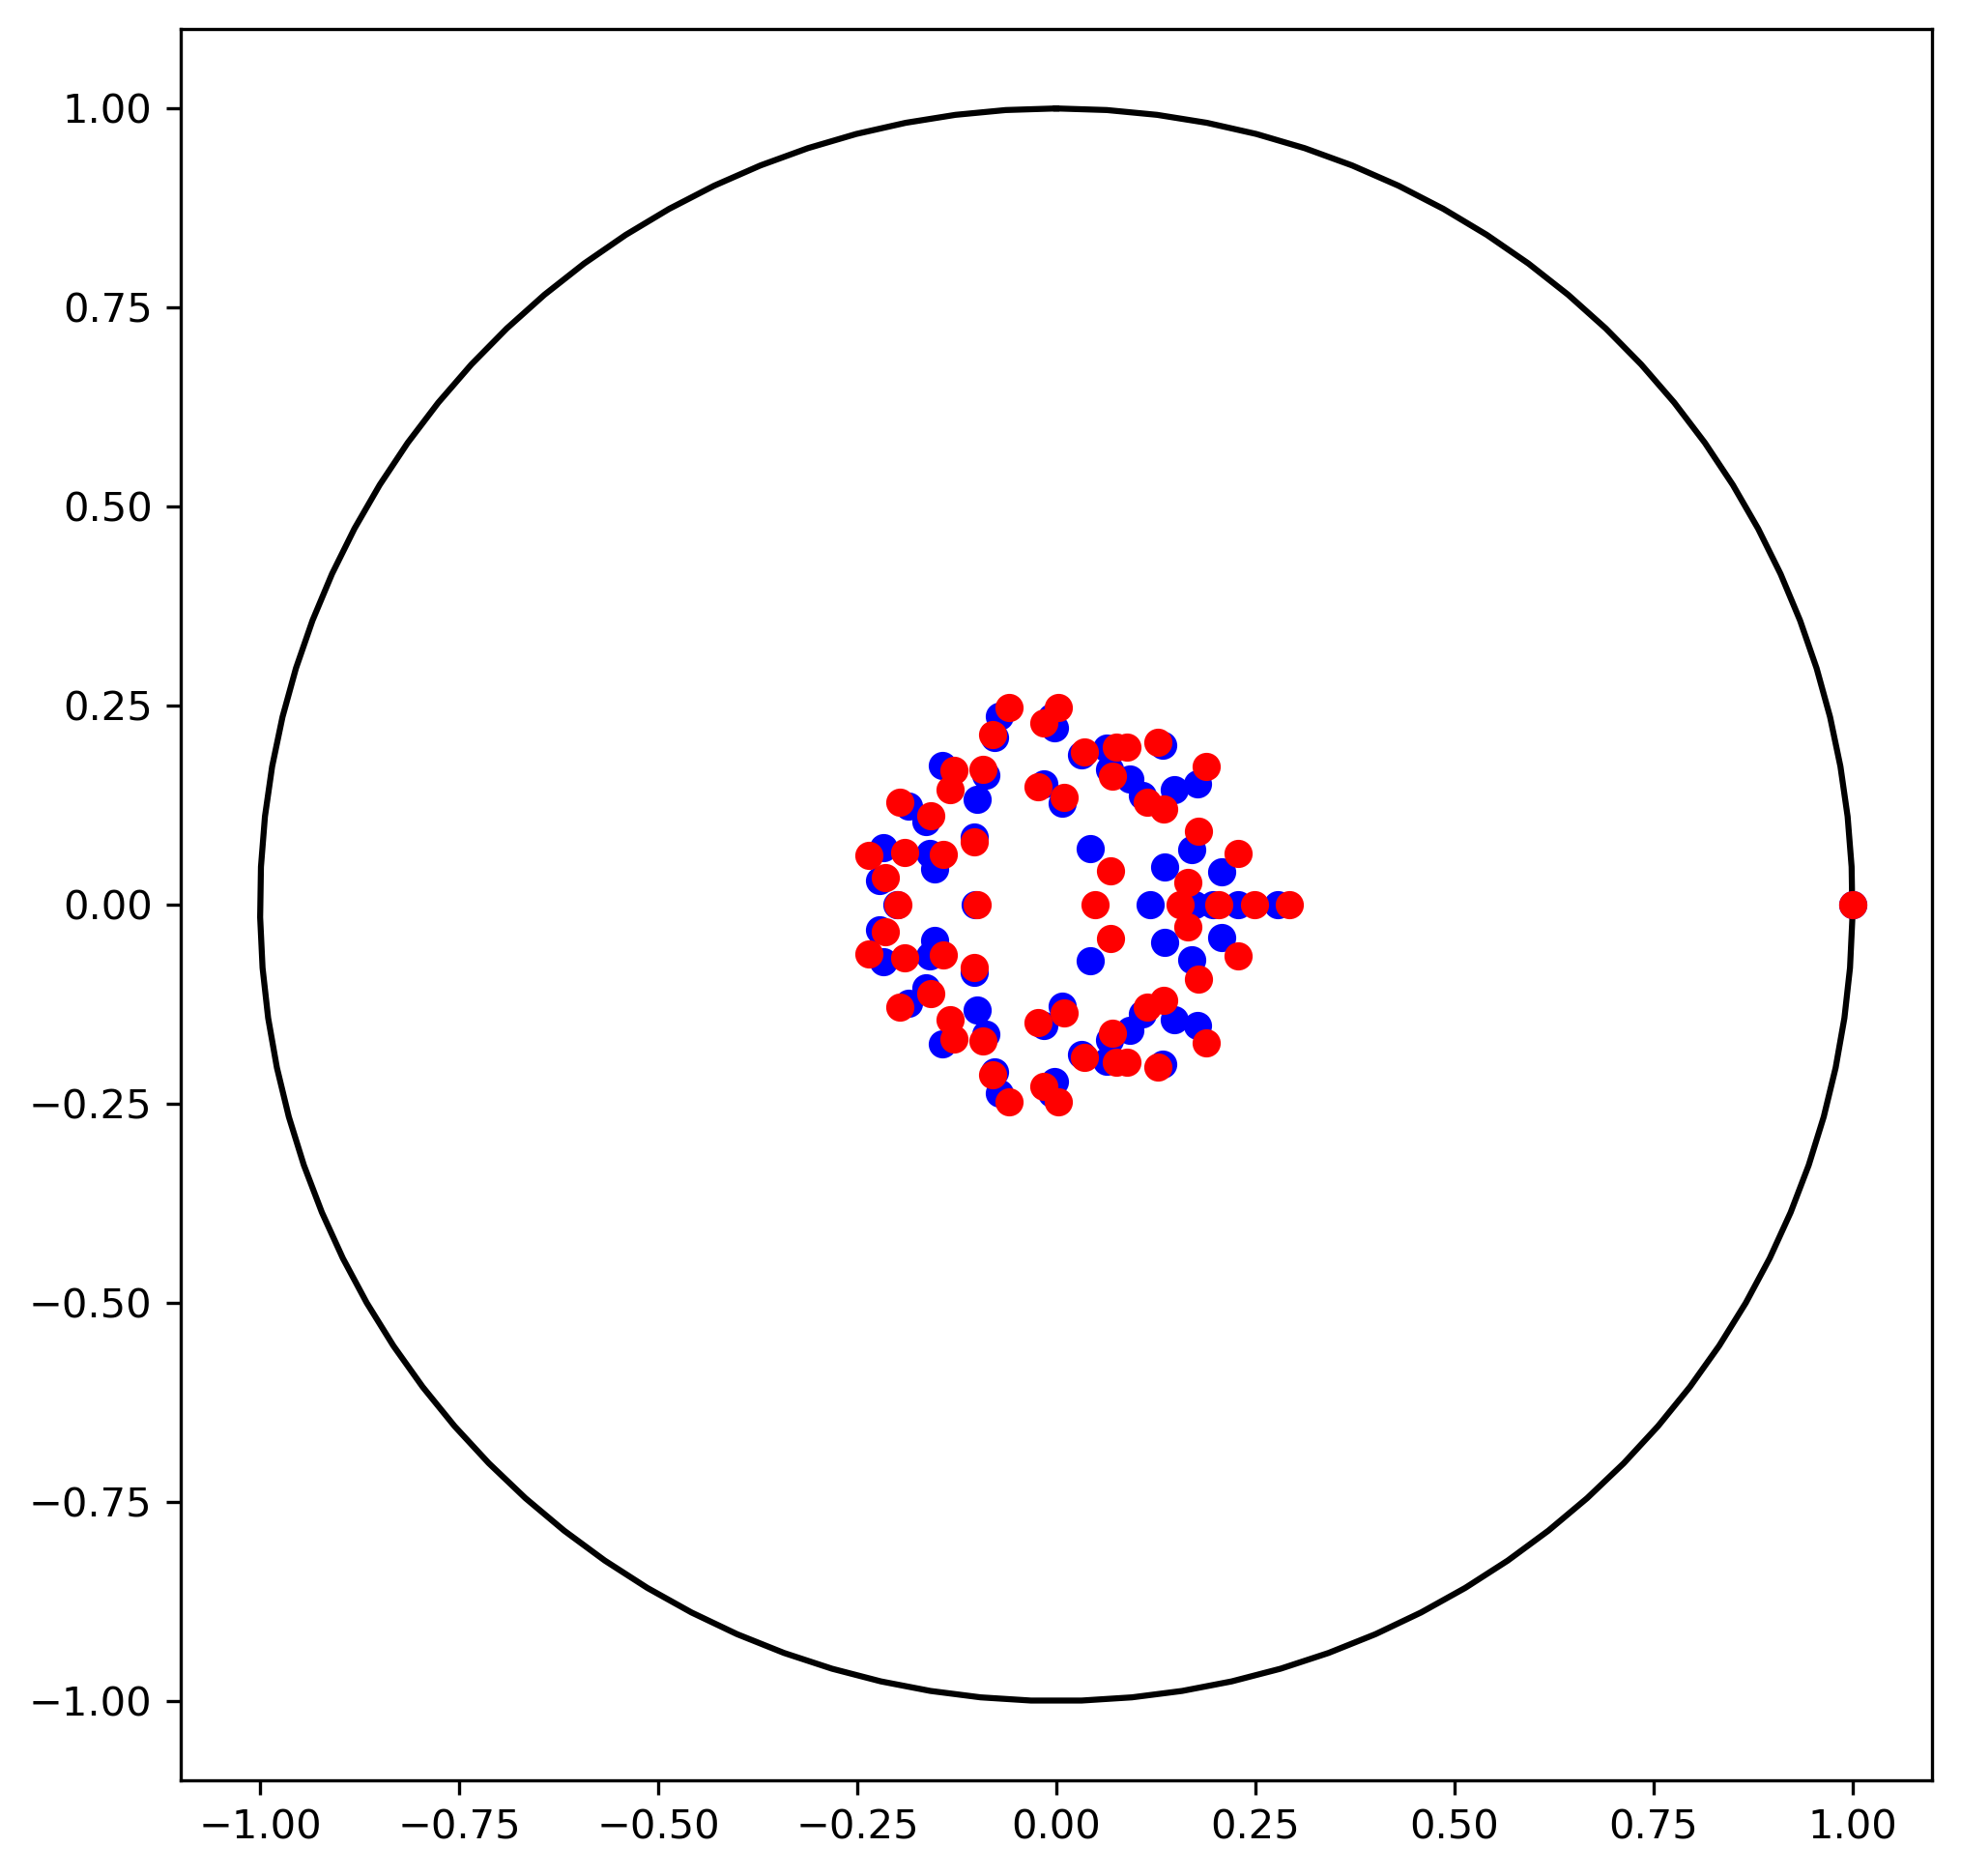

In [23]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model4[:,0], spectrum_model4[:,1], "bo")
plt.plot(spectrum_target4[:,0], spectrum_target4[:,1], "ro")

plt.show()

## Four Qubits

### Generate Random SPAM Data and Fit SPAM model

In [25]:
n = 4
d = 2**n
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_target2 = generate_spam_benchmark(n=n, 
                                      c1=0.9, 
                                      c2=0.9)

inputs_spam2, targets_spam2 = generate_spam_data(spam_target2, 
                                               N_spam=None, 
                                               shots=1024)

spam_model2 = SPAM(init = InitialState(d, c=0.9),
                   povm = CorruptionMatrix(d, c=0.9),
                   loss_function = ProbabilityMSE(),
                   optimizer = tf.optimizers.Adam(learning_rate=0.01)
                  )

spam_model2.train(inputs = inputs_spam2,
                  targets = targets_spam2,
                  num_iter = 3000,
                  verbose = False,
                 )

  0%|          | 0/3000 [00:00<?, ?it/s]

0.0008143033204524315


### Generate Random Channel Data and Fit Channel Model

In [26]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

channel_target1 = DilutedKrausMap(U = generate_unitary(d), 
                                 c = 0.2,
                                 kraus_part = KrausMap(d=d, 
                                                       rank=80),
                                 spam = spam_target)

inputs_map, targets_map = generate_map_data(channel_target, spam_target, N_map=10000-6**n, shots=1024)

model1 = ModelQuantumMap(channel = KrausMap(d = d, 
                                            rank = d**2,
                                            spam = spam_model4,
                                          ),
                        loss_function = ProbabilityMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = ProbabilityMSE(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model1.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [channel_target1],
            num_iter = 1000,
            N = 500,
            )

NameError: name 'spam_target' is not defined

In [37]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

channel_target = DilutedKrausMap(U = generate_unitary(d), 
                                 c = 0.9,
                                 kraus_part = KrausMap(d=d, 
                                                       rank=5),
                                 spam = spam_target)

inputs_map, targets_map = generate_map_data(channel_target, spam_target, N_map=10000-6**n, shots=1024)

model2 = ModelQuantumMap(channel = KrausMap(d = d, 
                                           rank = d**2,
                                           spam = spam_model4,
                                          ),
                        loss_function = ProbabilityMSE(),
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        logger = Logger(loss_function = ProbabilityMSE(),
                                        loss_function_val = channel_fidelity_loss),
                       )

model2.train(inputs = inputs_map,
            targets = targets_map,
            inputs_val = None,
            targets_val = [channel_target],
            num_iter = 1000,
            N = 500,
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

0.4891494015695996 -0.010788276799650193
0.25348400601940807 -0.19192949459627498
0.0383410553590611 -0.6334532985216662
0.017925063293144083 -0.7700517564536353
0.015947552569651174 -0.8088187194332364
0.015517363195129 -0.8249563029421338
0.015289806710951107 -0.8345466775067933
0.015101564813499587 -0.8420650370622679
0.01494535143886945 -0.8492893261646648
0.014813043871224896 -0.8565484707486832
tf.Tensor((0.015174503375105546-2.0487189065527566e-19j), shape=(), dtype=complex128)
0.014726252826861345 -0.8637264546565613


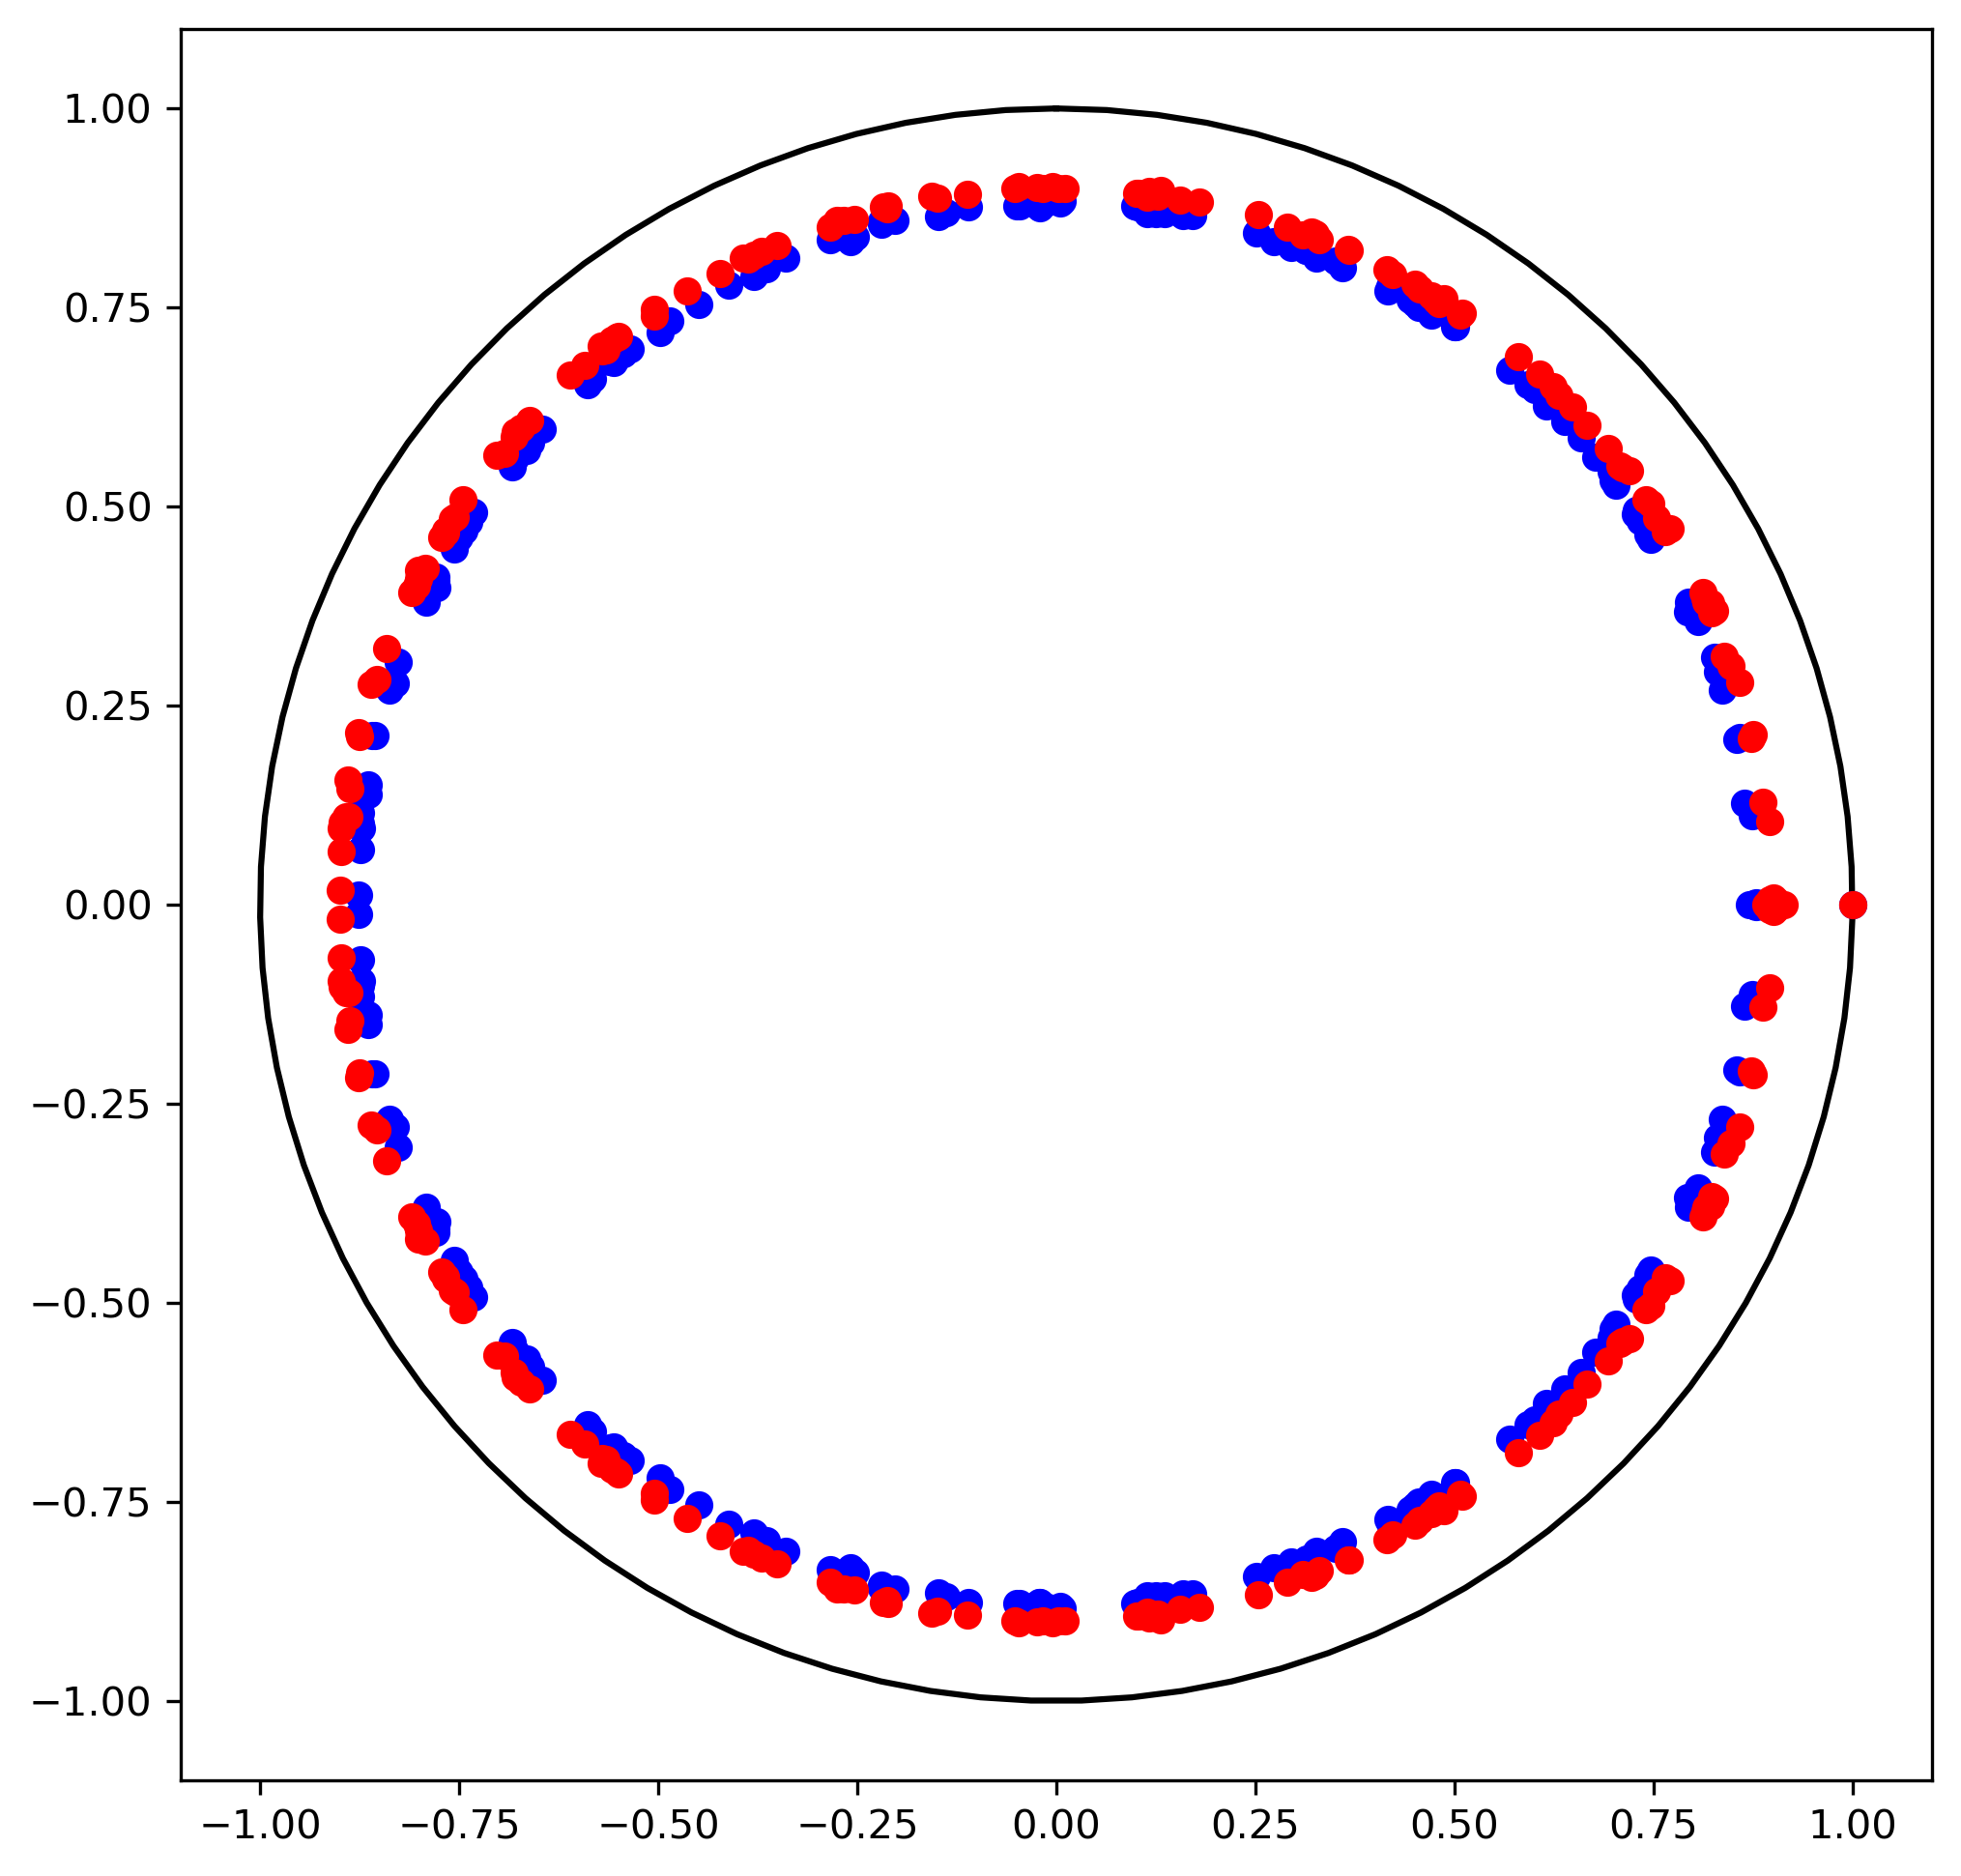

In [39]:
spectrum_model2 = channel_spectrum(model2.channel)
spectrum_target = channel_spectrum(channel_target)

t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "bo")
plt.plot(spectrum_target[:,0], spectrum_target[:,1], "ro")


plt.show()